In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import timm
import sys 
from torchinfo import summary
from scipy import signal
from scipy.stats import zscore
import pyVHR as vhr
import pickle
from typing import Optional
import math
import os
import random

import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms


from TorchLossComputer import TorchLossComputer
from TorchLossComputerCPU import TorchLossComputerCPU
from PhysFormer import ViT_ST_ST_Compact3_TDC_gra_sharp


2022-11-07 11:38:02.434016: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
PATCH_SIZE = 16
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * 3
NUM_PATCHES = 100
IMG_SIZE = PATCH_SIZE * NUM_PATCHES
HEADS = 12
BLOCKS = 12
BATCH = 300
LENGTH = 160

vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'

dataset_name = 'vipl_hr_v1'           
video_DIR = '/var/datasets/VHR1'  
BVP_DIR = '/var/datasets/VHR1'    

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

In [3]:
def chunks(lst, bvp, stride = 5, window = 160):
    tmp = []
    tmp_bvp = []
    for i in range(0, len(lst)-window, stride):
        tmp.append(torch.as_tensor(lst[i:i + window]))
        tmp_bvp.append(torch.as_tensor(bvp[i:i + window]))
    if tmp[-1].shape[0] != tmp[0].shape[0]:
        return(torch.stack(tmp[:-1]),torch.stack(tmp_bvp[:-1]))
    return(torch.stack(tmp),torch.stack(tmp_bvp))
        
#webs,train_bvp = chunks(webs,train_bvp,160)

In [4]:
def load_data(tot):
    min_len = 0
    train_video = []
    train_bvp = []
    val_video = []
    val_bvp = []
    test_video = []
    test_bvp = []
    for idx in range(0,tot):
        with open('/var/datasets/VIPL-HR-V1_webs/'+str(idx)+'-WEBS-'+str(PATCH_SIZE), 'rb') as f:
            #print('/var/datasets/PURE_webs/'+str(idx)+'-WEBS-'+str(PATCH_SIZE))
            (webs,labels) = pickle.load(f)
            if idx < ((tot/10)*9)-1:   #9 : 0 : 1
                train_video.append(webs)
                train_bvp.append(zscore(labels))
            #elif idx < (tot/10)*8+(tot/10):
                #print(2)
                #val_video.append(webs)
                #val_bvp.append(labels)
            else:
                #print(3)
                test_video.append(webs)
                test_bvp.append(zscore(labels))
            if min_len==0 or len(webs)<min_len:
                min_len = len(webs)
    for i in range(0,len(train_video)):
        train_video[i],train_bvp[i] = chunks(train_video[i][:min_len-1], train_bvp[i][:min_len-1])
    #for i in range(0,len(val_video)):
    #    val_video[i],val_bvp[i] = chunks(val_video[i][:min_len-1], val_bvp[i][:min_len-1],160)
    for i in range(0,len(test_video)):
        test_video[i],test_bvp[i] = chunks(test_video[i][:min_len-1], test_bvp[i][:min_len-1])
    return (train_video, train_bvp), (val_video, val_bvp), (test_video, test_bvp)


In [5]:
def save_ckp(model, optimizer, epoch, loss, iteration, path="."):
    checkpoint = {
        'epoch': epoch + 1,
        'iteration': iteration + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss
    }
    f_path = path + '/checkpoint.pt'
    torch.save(checkpoint, f_path)
    

In [6]:
def load_ckp(model, optimizer, path='./checkpoint.pt'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch'], checkpoint['iteration']

In [7]:
class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; i>0, 1- loss                                                                      
    def __init__(self):                                                           
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # all variable operation    
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])
            sum_y = torch.sum(labels[i])
            sum_xy = torch.sum(preds[i]*labels[i])
            sum_x2 = torch.sum(torch.pow(preds[i],2))
            sum_y2 = torch.sum(torch.pow(labels[i],2))
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))
            loss += 1 - pearson
        loss = loss/preds.shape[0]
        return loss

In [8]:
class AvgrageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = (self.sum / self.cnt).item()

In [9]:
(train_video,train_bvp),(val_video,val_bvp),(test_video,test_bvp) = load_data(7)

In [10]:
train_video, train_bvp = torch.cat(train_video[:]), torch.cat(train_bvp[:])
#val_video, val_bvp     = torch.cat(val_video[:]), torch.cat(val_bvp[:])
test_video, test_bvp   = torch.cat(test_video[:]), torch.cat(test_bvp[:])



In [21]:
print(train_video.shape,train_bvp.shape)

torch.Size([882, 160, 160, 160, 3]) torch.Size([882, 160])


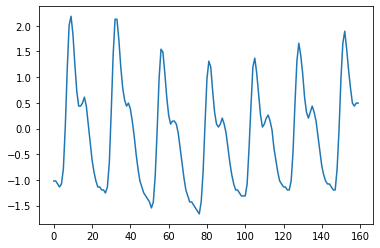

In [14]:
plt.plot(test_bvp[100])
plt.show()

In [18]:
clazz = {}
for frame in train_bvp:
    for bvp in video:
        if bvp.item() in clazz: clazz[bvp.item()] += 1
        else: clazz[bvp.item()] = 1
            
print(clazz)

NameError: name 'video' is not defined

In [19]:
for k in sorted(clazz.keys()):
    print(str(k) + ": "+ str(clazz[k]))

In [11]:
BATCH = 4
#train_video = train_video.permute(0,4,1,2,3)
#val_video = val_video.permute(0,4,1,2,3)
#test_video = test_video.permute(0,4,1,2,3)
print(train_video.shape,train_bvp.shape)
dataset = torch.utils.data.TensorDataset(train_video.permute(0,4,1,2,3),train_bvp)
trainloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH, shuffle=True, num_workers=1)

model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(160,160,160), patches=(4,16,16), dim=160, ff_dim=144, num_heads=4, num_layers=12, dropout_rate=0.1, theta=0.7)
print(summary(model))

optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.L1Loss()
criterion_Pearson = Neg_Pearson() 

loss = 0.0
epochs = 25

torch.Size([882, 160, 160, 160, 3]) torch.Size([882, 160])
Layer (type:depth-idx)                                            Param #
ViT_ST_ST_Compact3_TDC_gra_sharp                                  --
├─Conv3d: 1-1                                                     26,214,560
├─Transformer_ST_TDC_gra_sharp: 1-2                               --
│    └─ModuleList: 2-1                                            --
│    │    └─Block_ST_TDC_gra_sharp: 3-1                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-2                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-3                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-4                           1,485,904
├─Transformer_ST_TDC_gra_sharp: 1-3                               --
│    └─ModuleList: 2-2                                            --
│    │    └─Block_ST_TDC_gra_sharp: 3-5                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-6                          

In [12]:
def train(model, optimizer, trainloader, epoch_start=0, iter_start=0):
    criterion_reg = nn.MSELoss()
    criterion_L1loss = nn.L1Loss()
    criterion_class = nn.CrossEntropyLoss()
    criterion_Pearson = Neg_Pearson()
        
    a_start = 0.1
    b_start = 1.0
    exp_a = 0.5
    exp_b = 5.0
    
    writer = SummaryWriter()
    
    path_log = 'LOG'
    isExists = os.path.exists(path_log)
    if not isExists:
        os.makedirs(path_log)
    log_file = open(path_log+'/LOG_log.txt', 'w')
    
    for epoch in range(epoch_start, epochs):
        print("\nStarting epoch", epoch+1)
        loss = 0.0
        loss_rPPG_avg = AvgrageMeter()
        loss_peak_avg = AvgrageMeter()
        loss_kl_avg_test = AvgrageMeter()
        loss_bvp_mae = AvgrageMeter()
        
        model.train()
        for i, data in enumerate(trainloader,0):
            if i >= iter_start: 
                
                iter_start = 0
                inputs, targets = data
                inputs, targets = inputs.float().cuda(), targets.float().cuda()
                
                optimizer.zero_grad()
                rPPG = model(inputs,0.2) 
                rPPG = (rPPG-torch.mean(rPPG)) /torch.std(rPPG)
                #loss
                loss = criterion_reg
                loss_rPPG = criterion_Pearson(rPPG, targets)
                fre_loss = 0.0
                kl_loss = 0.0
                train_mae = 0.0
                """for bb in range(inputs.shape[0]):
                    loss_distribution_kl, fre_loss_temp, train_mae_temp = TorchLossComputer.cross_entropy_power_spectrum_DLDL_softmax2(
                        rPPG[bb], torch.mean(targets[bb].float()), 30, std=1.0) 
                    fre_loss = fre_loss + fre_loss_temp
                    kl_loss = kl_loss + loss_distribution_kl
                    train_mae = train_mae + train_mae_temp
                fre_loss = fre_loss/inputs.shape[0]
                kl_loss = kl_loss/inputs.shape[0]
                train_mae = train_mae/inputs.shape[0]
                print(train_mae)
                if epoch >25:
                    a = 0.05
                    b = 5.0
                else:
                    a = a_start*math.pow(exp_a, epoch/25.0)
                    b = b_start*math.pow(exp_b, epoch/25.0)
            
                a = 0.1
            
                loss =  a*loss_rPPG + b*(fre_loss+kl_loss)
                """
                #print(rPPG[0])
                #print(targets[0])
                
                #fre_loss = sum(sum(rPPG - targets)/4)
                #print(fre_loss)
                #print(loss_rPPG)
                
                loss = loss_rPPG 
                loss.backward()
                optimizer.step()
                
                n = inputs.size(0)
                loss_rPPG_avg.update(loss_rPPG.data, n)
                #loss_peak_avg.update(fre_loss.data, n)
                #loss_kl_avg_test.update(kl_loss.data, n)
                #loss_bvp_mae.update(train_mae, n)
                
                sys.stdout.write('\r')
                sys.stdout.write(f"Iteration {i+1}, loss= {loss/((i+1)*inputs.shape[0]):1.5f}, NegPearson= {loss_rPPG_avg.avg:1.5f}, kl= {loss_kl_avg_test.avg:1.5f}, fre_CEloss= {loss_peak_avg.avg:1.5f}")
                sys.stdout.flush()
                
                writer.add_scalar('Epoch '+str(epoch)+' Loss/train', loss/((i+1)*inputs.shape[0]), i)

                save_ckp(model, optimizer, loss, epoch, i)
                
                if( i%50 == 0):
                    log_file.write("\n")        
                    log_file.write(f"Epoch {epoch+1}, Iteration {i+1}, loss= {loss/((i+1)*inputs.shape[0]):1.5f}, NegPearson= {loss_rPPG_avg.avg:1.5f}, kl= {loss_kl_avg_test.avg:1.5f}, fre_CEloss= {loss_peak_avg.avg:1.5f}")
                    log_file.write("\n")
                    log_file.write("\n")
                    log_file.flush()
                

    return model, loss, loss_rPPG_avg, loss_peak_avg, loss_kl_avg_test, loss_bvp_mae



In [13]:
model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(160,160,160), patches=(4,16,16), dim=160, ff_dim=144, num_heads=4, num_layers=12, dropout_rate=0.1, theta=0.7)
model = model.cuda()
model.train() 
print("iterations per epoch: ",len(trainloader)) 
print("epochs: {0}\nStart".format(epochs)) 
train(model,optimizer,trainloader, 0,0) 
print('\nTraining process has finished.')

iterations per epoch:  221
epochs: 25
Start

Starting epoch 1
Iteration 23, loss= 0.01119, NegPearson= 0.99052, kl= 0.00000, fre_CEloss= 0.00000

KeyboardInterrupt: 

In [13]:
#LOAD MODEL

epochs = 5
model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(160,160,160), patches=(4,16,16), dim=160, ff_dim=144, num_heads=4, num_layers=12, dropout_rate=0.1, theta=0.7)
optimizer = torch.optim.Adam(model.parameters())
model, optimizer, epoch, iteration = load_ckp(model,optimizer,'./ViTVHR_PURE.pt')
#train(model,optimizer, trainloader, epoch, iteration)

In [14]:

#train_video = train_video.permute(0,4,1,2,3)
#val_video = val_video.permute(0,4,1,2,3)
#test_video = test_video.permute(0,4,1,2,3)
def test_chunk1(model):
    print(test_video.shape,test_bvp.shape)
    dataset = torch.utils.data.TensorDataset(test_video.permute(0,4,1,2,3),test_bvp)
    testloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=1)
    model = model.cuda()
    model.eval()
    
    rPPG = []
    
    with torch.no_grad():
        for i, data in enumerate(testloader):
            inputs, targets = data
            inputs, targets = inputs.float().cuda(), targets.float().cuda()
            rPPG.append((model(inputs, 2.0).cpu()[0],targets.cpu()[0]))
    return rPPG
    
rPPG = test_chunk1(model)


torch.Size([357, 160, 160, 160, 3]) torch.Size([357, 160])


In [15]:
with open('rPPG', 'wb') as f:
    pickle.dump(rPPG,f)

In [20]:
rPPG[r[0]][1]

tensor([24., 31., 43., 57., 64., 62., 57., 51., 45., 43., 43., 44., 44., 43.,
        40., 37., 33., 31., 29., 26., 26., 25., 24., 23., 27., 38., 53., 66.,
        70., 67., 62., 57., 52., 49., 48., 48., 49., 46., 42., 39., 36., 32.,
        30., 28., 27., 26., 25., 26., 31., 44., 60., 71., 72., 69., 64., 59.,
        54., 51., 50., 49., 48., 45., 41., 38., 34., 31., 28., 26., 25., 24.,
        24., 24., 28., 40., 55., 66., 68., 63., 55., 51., 46., 45., 44., 45.,
        42., 40., 36., 33., 29., 26., 25., 24., 23., 23., 22., 23., 31., 44.,
        57., 62., 60., 54., 49., 44., 42., 42., 43., 42., 40., 38., 34., 31.,
        29., 27., 26., 25., 24., 24., 23., 27., 37., 51., 62., 63., 59., 54.,
        50., 45., 43., 44., 44., 43., 40., 38., 34., 31., 28., 26., 26., 25.,
        24., 24., 23., 27., 36., 51., 63., 67., 64., 59., 55., 51., 47., 46.,
        45., 45., 42., 39., 35., 32.])

[146, 166, 215, 146, 166, 215]


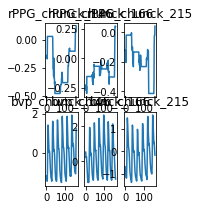

In [16]:
r=[random.randint(0,len(rPPG)),random.randint(0,len(rPPG)),random.randint(0,len(rPPG))]
r=r+r
print(r)
fig = plt.figure(figsize=(2, 3))
for i in range(6):
    x = i%2
    y = i//2
    ax = fig.add_subplot(2, 3, i+1)
    if(i<3):
        ax.title.set_text("rPPG_chunck_"+str(r[i]))
        ax.plot(rPPG[r[i]][0]) 
    else:
        ax.title.set_text("bvp_chunck_"+str(r[i]))
        ax.plot(rPPG[r[i]][1]) 
    

plt.show()

In [ ]:
writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [ ]:
with open('epoch_loss.sv', 'rb') as f:
    loss = pickle.load(f)

In [ ]:
with torch.no_grad(): 
    for data in testloader: 
        inputs, targets = data 
        inputs, targets = inputs.float(), targets.float()
        predicted_outputs = model(inputs,0.2) 
        print(predicted_outputs[0][0])
        print(targets[0][0])

        #_, predicted = torch.max(predicted_outputs, 1) 
        #total += outputs.size(0) 
        #running_accuracy += (predicted == outputs).sum().item() 

    #print('Accuracy of the model based on the test set of', test_split ,'inputs is: %d %%' % (100 * running_accuracy / total))    


In [ ]:
#train_bvp = signal.resample(sigGT.data, len(webs))
print(webs.shape,torch.as_tensor(train_bvp).shape)
dataset = torch.utils.data.TensorDataset(webs,torch.as_tensor(train_bvp))
trainloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=1)



In [ ]:
model.eval()
accuracy = 0.0
total = 0.0
    
with torch.no_grad():
    for i, data in enumerate(trainloader, 1):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        err = torch.abs(torch.mean(outputs,1)- targets).item()
        total = i
        accuracy += err
        sys.stdout.write('\r')
        sys.stdout.write(f"Iteration {i}, Accuracy: {accuracy/total:1.5f} {outputs}")
        sys.stdout.flush()

print(accuracy)

In [ ]:
PATCH_SIZE = 15
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * 3
NUM_PATCHES = 100
IMG_SIZE = PATCH_SIZE * NUM_PATCHES
HEADS = 5
BLOCKS = 12

class PatchEmbed(nn.Module):
  def __init__(self, img_size, patch_size, in_chans=3, embed_dim=EMBED_DIM):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size // patch_size) ** 2
    self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = torch.movedim(x,3,1)
    x = self.proj(x)       # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
    x = x.flatten(2)        # (n_samples, embed_dim, n_patches)
    x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

    return x

class Attention(nn.Module):


  def __init__(self, dim, n_heads=HEADS, qkv_bias=True, attn_p=0., proj_p=0.):
    super().__init__()
    self.n_heads = n_heads
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x):
    n_samples, n_tokens, dim = x.shape

    if dim != self.dim:
      raise ValueError

    qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
    qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, n_samples, n_heads, n_patches + 1, head_dim)

    # compute att matrices
    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1)   # (n_samples, n_heads, head_dim, n_patches + 1)
    dp = (q @ k_t) * self.scale

    attn = dp.softmax(dim=-1)   # (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = self.attn_drop(attn)

    # compute weigthed avg
    weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
    weighted_avg = weighted_avg.transpose(1, 2)  # (n_samples, n_patches + 1, n_heads, head_dim)
    weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

    # linear projection
    x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
    x = self.proj_drop(x)        # (n_samples, n_patches + 1, dim)

    return x

class MLP(nn.Module):

    def __init__(self, in_features, hidden_features, out_features, p=0.):
      super().__init__()
      self.fc1 = nn.Linear(in_features, hidden_features)
      self.act = nn.GELU()
      self.fc2 = nn.Linear(hidden_features, out_features)
      self.drop = nn.Dropout(p)

    def forward(self, x):
      x = self.fc1(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.act(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
      x = self.fc2(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)

      return x

class Block(nn.Module):
    
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
      super().__init__()
      self.norm1 = nn.LayerNorm(dim, eps=1e-6)
      self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_p=attn_p, proj_p=p)
      self.norm2 = nn.LayerNorm(dim, eps=1e-6)
      hidden_features = int(dim * mlp_ratio)
      self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim)

    def forward(self, x):
     
      
      x = x + self.attn(self.norm1(x))
      x = x + self.mlp(self.norm2(x))

      return x

class VisionTransformer(nn.Module):
  
  def __init__(
          self,
          img_size=IMG_SIZE,
          patch_size=PATCH_SIZE,
          in_chans=3,
          n_classes=1000,
          embed_dim=EMBED_DIM,
          depth=BLOCKS,
          n_heads=HEADS,
          mlp_ratio=4.,
          qkv_bias=True,
          p=0.,
          attn_p=0.,
  ):
    super().__init__()

    self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
    )
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
    )
    self.pos_drop = nn.Dropout(p=p)

    self.blocks = nn.ModuleList(
        [
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=attn_p,
            )
            for _ in range(depth)
        ]
    )

    self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
    self.head = nn.Linear(embed_dim, n_classes)
    self.lastConv = nn.Conv1d(embed_dim, 1,1,stride=1, padding=0)
    
  def forward(self, x):
    n_samples = x.shape[0]
    x = self.patch_embed(x)  #(n_samples, n_patches, embed_dim)
    
    
    cls_token = self.cls_token.expand(n_samples, -1, -1)  # (n_samples, 1, embed_dim)
    x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
    #x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
    x = self.pos_drop(x)

    for block in self.blocks:
      x = block(x)

    x = self.norm(x)

    cls_token_final = x[:, 0]  # just the CLS token
    #x = self.head(cls_token_final)
    #x = x.type(torch.DoubleTensor)
    #x = torch.mean(x,1)
    #x = torch.mean(x,1)
    x = x.permute(0, 2, 1) 
    x = self.lastConv(x)
    x = x.squeeze(1)
    
    return x
